### Robot Learning


In [1]:
!apt-get -qq install python-opengl xvfb x11-utils &> /dev/null
!pip install ufal.pybox2d --quiet &> /dev/null
!pip install pyvirtualdisplay moviepy pyglet PyOpenGL-accelerate --quiet &> /dev/null

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import random

  from scipy.ndimage.filters import sobel



In [3]:
# set up showing animations from the environment in Colab.
Display(visible=False).start()

## Supervised Learning

I use the prediction of continuous function values using supervised learning in which a toy dataset containing samples $(x, y=f(x))$ is used to fit a fully connected neural network to the polynomial $f$.

In [4]:
## define the toy dataset
class ToyPolynomialDataset(Dataset):
    def __init__(self, samples, A, B, C):
        self.samples = samples
        self.targets = A*torch.pow(self.samples, 2) + B*self.samples+ C

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):
        return torch.atleast_1d(self.samples[idx]), torch.atleast_1d(self.targets[idx])

## characterize the polynomial f
A, B, C = 5, 3, -2
## discretize sampling interval of f
samples = torch.linspace(-10, 10, steps=64)
## split into training and validation data
indices = list(range(samples.shape[0]))
split = int(np.ceil(0.8 * samples.shape[0]))
np.random.shuffle(indices)
train_idx, valid_idx = indices[:split], indices[split:]
## create training and validation datasets
train_data = ToyPolynomialDataset(samples[train_idx], A, B, C)
valid_data = ToyPolynomialDataset(samples[valid_idx], A, B, C)
## create corresponding dataloaders, which handle batching and shuffling
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=False)

In [5]:
## define a model to approximate f
class Net(nn.Module):
    def __init__(self, input_dim=1, hidden_layer_dim=8, output_dim=1):
        super(Net, self).__init__()
        # Create some fully connected layers
        self.layers = [nn.Linear(input_dim, hidden_layer_dim, bias=True),
                       nn.LeakyReLU(),

                       nn.Linear(hidden_layer_dim, hidden_layer_dim, bias=True),
                       nn.LeakyReLU(),

                       nn.Linear(hidden_layer_dim, output_dim, bias=True)]
        # Combine these layers into a neural network
        self.net = nn.Sequential(*self.layers)

    def forward(self, s):
        # Convert input state to tensor if necessary
        # np_check does absolutely nothing here, but deals with open ai gym states
        np_check = type(s) is np.ndarray
        x = torch.from_numpy(s).float().view(1,-1).to(next(self.parameters()).device) if np_check else s
        # Map state to action vector
        x = self.net(x)
        # Return format of action based on input type
        return np.clip(x.squeeze().detach().cpu().numpy(),-1,1) if np_check else x

In [6]:
## check if there is a gpu available - if so, use it
# you can activate one at Edit→Notebook Settings, but don't need to
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)
# create an instance of your model
model = Net().to(device)
# define a criterion, setup optimizer and schedule to reduce learning rate
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-6)

Using device: cuda


In [7]:
## typical layout of a neural regression task:
# -> alternate validation and training epochs, track losses
N_EPOCHS = 2500

best_valid_loss = 1e25
losses_train, losses_valid = [], []
progress_bar = tqdm(range(N_EPOCHS), total=N_EPOCHS, position=0, leave=True)
for i in progress_bar:
    # validation epoch
    loss_valid = 0
    # important to set model to eval mode for some layers (like dropout)
    model.eval()
    # don't need gradients for validation
    with torch.no_grad():
        # dataloaders provide batches of training samples and targets
        for x_valid, y_valid in valid_loader:
            x_valid, y_valid = x_valid.to(device), y_valid.to(device)
            net_out_valid = model(x_valid)
            # loss between network output and target
            loss_valid += criterion(net_out_valid, y_valid)
    # keep track of losses
    losses_valid.append(loss_valid.item()/len(valid_data))
    # if the valid loss is best so far, save model
    if losses_valid[-1] < best_valid_loss:
        best_valid_loss = losses_valid[-1]
        torch.save(model.state_dict(), 'best_weights.pth')

    # training epoch
    loss_train_sum = 0
    # important to set model to train mode for some layers (like dropout)
    model.train()
    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        net_out = model(x_train)
        loss_train = criterion(net_out, y_train)
        # this term keeps track of the loss
        loss_train_sum += loss_train.item()
        loss_train /= x_train.shape[0]
        # backprop error and update network weights
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    losses_train.append(loss_train_sum/len(train_data))
    learning_rates = np.array([g['lr'] for g in optimizer.param_groups])
    # Show current training stats
    episode_summary = [f"{i+1}:"] + [f'Train: {losses_train[-1]}, Valid: {losses_valid[-1]}, LR: {learning_rates.mean()}']
    # Set progress bar
    progress_bar.set_description("".join(episode_summary))
    # Decrease learning rate if necessary
    scheduler.step(losses_valid[-1])
# Optional - set model to the best encountered during training
model.load_state_dict(torch.load('best_weights.pth'))
model.eval()
print('Training completed!')

  0%|          | 0/2500 [00:00<?, ?it/s]

Training completed!


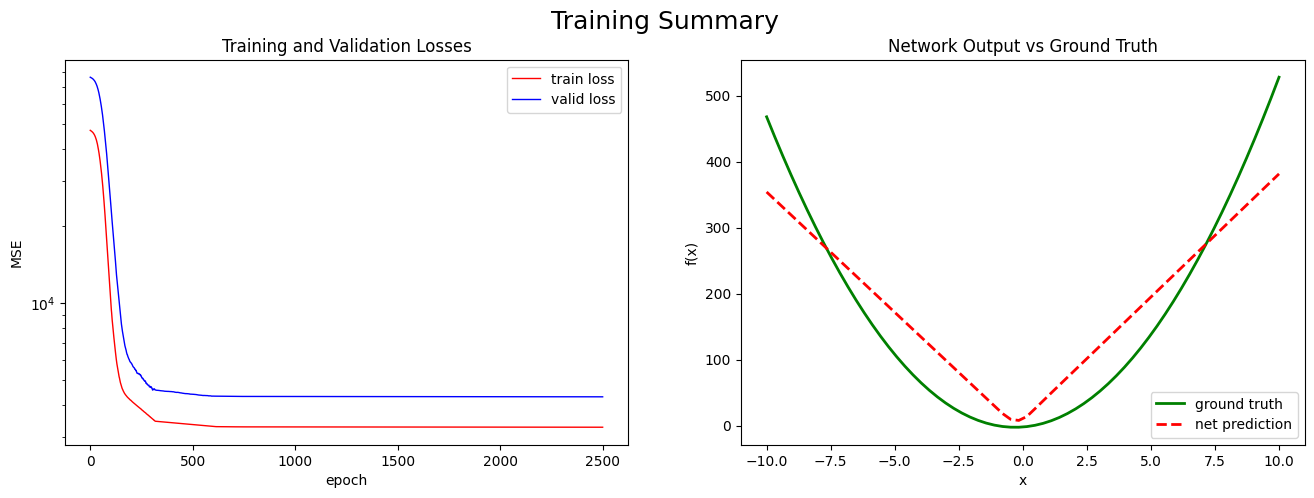

In [8]:
# Get ground truth and network prediction
gt = A*torch.pow(samples, 2) + B*samples + C
with torch.no_grad():
    net_out = model(samples.view(-1,1).to(device)).cpu().numpy()
# Finally plot the learning curves and the approximated function
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,5)
fig.suptitle('Training Summary', fontsize=18)
ax[0].plot(np.array(losses_train), label='train loss', c='r', lw=1)
ax[0].plot(np.array(losses_valid), label='valid loss', c='b', lw=1)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("MSE")
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title('Training and Validation Losses')

ax[1].plot(samples, gt, label='ground truth', c='g', lw=2)
ax[1].plot(samples, net_out, label='net prediction', c='r', lw=2, ls='--')
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].legend(loc="lower right")
ax[1].set_title('Network Output vs Ground Truth')
plt.show()

First fully connected layer:
Input dimension: 1
Output dimension (hidden_layer_dim): 8
Bias terms: 8 (one for each neuron in the output)
Total parameters: (1 * 8) + 8 = 16
Second fully connected layer:
Input dimension: 8 (output dimension of the previous layer)
Output dimension (hidden_layer_dim): 8 (specified in the model constructor)
Bias terms: 8
Total parameters: (8 * 8) + 8 = 72
Third fully connected layer:
Input dimension: 8
Output dimension: 1
Bias term: 1
Total parameters: (8 * 1) + 1 = 9
Therefore, the total number of optimized parameters in the model is the sum of the parameters in each layer: 16 + 72 + 9 = 97.

both the training and validation losses have plateaued and the model's performance is satisfactory, it may not be necessary to add more parameters or layers.

Validation Loss: The validation loss is consistently higher than the training loss, it indicates that the model is not generalizing well to unseen data. This could be a sign of overfitting, as the model has become too specific to the training data and is unable to generalize to new examples.

## Behavioral Cloning

Suppose you are given a complicated RL environment with an $N$-dimensional state space and a $D$-dimensional continous action space as well as a human expert who can perform well in this environment using a joystick.


To apply behavioral cloning in a complicated RL environment with an N-dimensional state space and a D-dimensional continuous action space. Here are the specific steps and adjustments required:

1. Data Collection:
   - Have the human expert interact with the RL environment using a joystick or any other suitable input device.
   - Record the expert's actions and the corresponding state observations during their interactions.
   - Collect a sufficient amount of expert demonstration data to cover a diverse range of state-action pairs.

2. Adjustments to the Training Procedure:
   - Modify the data loading and preprocessing steps to incorporate the expert demonstration data.
   - Combine the expert demonstration data with the RL environment data to create a joint dataset for training.
   - Ensure that the dataset contains both state observations and the corresponding expert actions.
   - Adjust the hyperparameters used in the training process accordingly, based on the characteristics of the environment and the expert data.
   - You may need to experiment with the hyperparameters to achieve optimal performance. Some hyperparameters to consider adjusting include learning rate, batch size, and the number of training epochs.

3. Adjustments to the Model:
   - Adapt the generator model architecture to handle the N-dimensional state space and the D-dimensional continuous action space.
   - The input layer of the generator should match the dimensionality of the state space, and the output layer should match the dimensionality of the action space.
   - Modify the loss function to incorporate the behavioral cloning objective, which minimizes the difference between the generated actions and the expert actions.
   - You may need to experiment with different loss functions, such as mean squared error or other suitable regression losses, to effectively learn from the expert demonstrations.

4. Evaluation and Fine-tuning:
   - After training the model using behavioral cloning, evaluate its performance in the RL environment.
   - Compare the model's performance with the expert's performance to assess the effectiveness of the behavioral cloning approach.
   - If necessary, fine-tune the model using reinforcement learning techniques, such as using the generated data to train a reinforcement learning agent through techniques like Proximal Policy Optimization (PPO) or Deep Q-Networks (DQN).


## Bipedal Walker v3

Familiarize yourself with the Gym environment [Bipedal Walker v3](https://gymnasium.farama.org/environments/box2d/bipedal_walker/) by examing the code below, which simulates and animates one episode using the random agent.

In [9]:
# Create the environment
env = gym.make('BipedalWalker-v3')
# Reset the environment
state = env.reset()
# Track whether the episode is over
done = False
# List to append the frames produced by the environment renderer
frames = []
while not done:
    # Render current situation and append to frames
    frames.append(env.render('rgb_array'))
    # Select a random action
    action = env.action_space.sample()
    # Execute this action
    state, reward, done, info = env.step(action)
# Print the number of frames
print('Number of frames:', len(frames))
# Prevent the renderer from showing artifacts
plt.close()

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Number of frames: 76


In [10]:
# Helper function to animate a list of frames as produced above
def visualize_trajectory(frames, fps=30):
  duration = int(len(frames) // fps + 1)
  fig, ax = plt.subplots()
  def make_frame(t, ind_max=len(frames)):
      ax.clear()
      ax.imshow(frames[min((int(fps*t),ind_max-1))])
      return mplfig_to_npimage(fig)
  plt.close()
  return VideoClip(make_frame, duration=duration)

In [11]:
# Get the animation from the frames of the played episode
animation = visualize_trajectory(frames)
# Show the animation
animation.ipython_display(fps=30, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Additionally, examine the cells below, which download and setup dataloaders for expert traces from 256 episodes for training and 24 episodes for validation. In this case the expert was simulated using a walking heuristic provided by Gym.

In [12]:
# download the data
!wget https://github.com/JanNogga/rl_ss23/raw/main/walker_heuristic_train.pt &> /dev/null
!wget https://github.com/JanNogga/rl_ss23/raw/main/walker_heuristic_valid.pt &> /dev/null
# define dataset
class HeuristicWalkerDataset(Dataset):
    def __init__(self, f):
        data = torch.load(f)
        self.states, self.actions = data['states'].float(), data['actions'].float()

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, idx):
        # output is s, a --- ready for batching in dataloader
        return self.states[idx], self.actions[idx]

In [13]:
# create the datasets for training and validation
walker_train_data = HeuristicWalkerDataset(f='walker_heuristic_train.pt')
walker_valid_data = HeuristicWalkerDataset(f='walker_heuristic_valid.pt')

# create the corresponding dataloaders
walker_train_loader = DataLoader(walker_train_data, batch_size=256, shuffle=True)
walker_valid_loader = DataLoader(walker_valid_data, batch_size=1024, shuffle=False)

Use behavioral cloning to learn a policy for BipedalWalker-v3. 

Measured by average MSE with respect to the training data, the agent should score lower than $0.009$ as weak baseline. Without too much overfitting, the agent should start properly walking at an average training MSE of around $0.0015$. Training is possible in less than 20 minutes, but will be slightly faster if the GPU capabilities are activated.


In [14]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt


Define the BipedalWalkerDataset:

In [15]:
class BipedalWalkerDataset(Dataset):
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        state = self.states[idx]
        action = self.actions[idx]
        return state, action


Define the neural network model:


In [16]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.layers(x)


Set up the training and validation data:

In [17]:
# Load the expert data
expert_data = torch.load('walker_heuristic_train.pt')
states = expert_data['states'].float()
actions = expert_data['actions'].float()

# Split the data into training and validation sets
split_ratio = 0.8
split_idx = int(len(states) * split_ratio)
train_states, train_actions = states[:split_idx], actions[:split_idx]
valid_states, valid_actions = states[split_idx:], actions[split_idx:]

# Create the datasets
train_dataset = BipedalWalkerDataset(train_states, train_actions)
valid_dataset = BipedalWalkerDataset(valid_states, valid_actions)

# Create the dataloaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


Define the training loop:

In [18]:
def train(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for states, actions in train_loader:
            optimizer.zero_grad()
            outputs = model(states)
            loss = criterion(outputs, actions)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            for states, actions in valid_loader:
                outputs = model(states)
                loss = criterion(outputs, actions)
                valid_loss += loss.item()

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        scheduler.step(valid_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    return train_losses, valid_losses


Train the model:


In [20]:
input_dim = train_states.shape[1]
output_dim = train_actions.shape[1]
model = Net(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)
num_epochs = 50

train_losses, valid_losses = train(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs)


Epoch 1/50: Train Loss: 0.0212, Valid Loss: 0.0109
Epoch 2/50: Train Loss: 0.0093, Valid Loss: 0.0076
Epoch 3/50: Train Loss: 0.0073, Valid Loss: 0.0059
Epoch 4/50: Train Loss: 0.0061, Valid Loss: 0.0051
Epoch 5/50: Train Loss: 0.0054, Valid Loss: 0.0047
Epoch 6/50: Train Loss: 0.0050, Valid Loss: 0.0044
Epoch 7/50: Train Loss: 0.0046, Valid Loss: 0.0042
Epoch 8/50: Train Loss: 0.0043, Valid Loss: 0.0037
Epoch 9/50: Train Loss: 0.0041, Valid Loss: 0.0040
Epoch 10/50: Train Loss: 0.0040, Valid Loss: 0.0035
Epoch 11/50: Train Loss: 0.0038, Valid Loss: 0.0033
Epoch 12/50: Train Loss: 0.0037, Valid Loss: 0.0036
Epoch 13/50: Train Loss: 0.0035, Valid Loss: 0.0032
Epoch 14/50: Train Loss: 0.0034, Valid Loss: 0.0029
Epoch 15/50: Train Loss: 0.0034, Valid Loss: 0.0031
Epoch 16/50: Train Loss: 0.0034, Valid Loss: 0.0034
Epoch 17/50: Train Loss: 0.0032, Valid Loss: 0.0034
Epoch 18/50: Train Loss: 0.0032, Valid Loss: 0.0028
Epoch 19/50: Train Loss: 0.0031, Valid Loss: 0.0032
Epoch 20/50: Train Lo

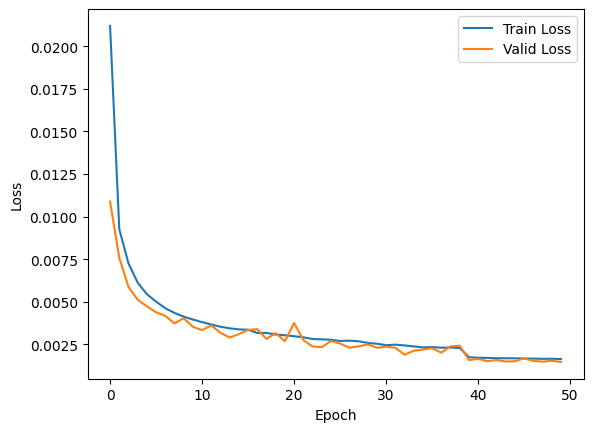

In [21]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Define the inference function:

In [22]:
def infer(model, state):
    model.eval()
    with torch.no_grad():
        state = torch.tensor(state).unsqueeze(0)
        action = model(state).squeeze(0).numpy()
    return action


Animate an episode of the agent walking:


In [23]:
env = gym.make('BipedalWalker-v3')
state = env.reset()
done = False
frames = []

while not done:
    frames.append(env.render(mode='rgb_array'))
    action = infer(model, state)
    state, _, done, _ = env.step(action)

env.close()


Visualize the animation:


In [24]:
def visualize_trajectory(frames, fps=30):
    duration = int(len(frames) / fps + 1)
    fig, ax = plt.subplots()

    def make_frame(t, ind_max=len(frames)):
        ax.clear()
        ax.imshow(frames[min(int(fps * t), ind_max - 1)])
        return mplfig_to_npimage(fig)

    animation = VideoClip(make_frame, duration=duration)
    plt.close()
    return animation

animation = visualize_trajectory(frames)
animation.ipython_display(fps=30, loop=True, autoplay=True)


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
